In [19]:
import re
import nltk
import spacy
import unidecode
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from textblob import TextBlob
from spellchecker import SpellChecker
from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [2]:
spell = SpellChecker()
scy = spacy.load("en_core_web_sm")
nltk_sw = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [3]:
# Load pickle file with balanced dataframe
with open(r'pickles\balanced_retokenized.pickle', 'rb') as f:
    data = pickle.load(f)

### Representação vetorial (Tf-Idf)

In [4]:
# Split data into features (X) and label (y)
X_data = np.array(data['title'])
y_data = np.array(data['label'])

# Apply Tf-Idf representation
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer = vectorizer.fit(X_data)
X_data = vectorizer.transform(X_data)

### Redução de Dimensionalidade

#### Extração de Features (LSA - TruncatedSVD)

In [5]:
LSA = TruncatedSVD(n_components=100, n_iter=150, random_state=0)
LSA = LSA.fit(X_data)
X_data = LSA.transform(X_data)

## Modelagem de algoritmos

### Testes experimentais

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)

exp_NB = GaussianNB().fit(X_train, y_train)
exp_LR = LogisticRegression().fit(X_train, y_train)
exp_KNN = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
exp_SVM = SVC(kernel='rbf').fit(X_train, y_train)
exp_MLP = MLPClassifier(hidden_layer_sizes=(30,30,15), activation='relu', max_iter=1000).fit(X_train, y_train)

exp_NB_pred = exp_NB.predict(X_test)
exp_LR_pred = exp_LR.predict(X_test)
exp_KNN_pred = exp_KNN.predict(X_test)
exp_SVM_pred = exp_SVM.predict(X_test)
exp_MLP_pred = exp_MLP.predict(X_test)

print('======== RESULTADOS DOS TESTES EXPERIMENTAIS =======')
print(f'Base Gaussian Naive Bayes - recall: {round(recall_score(y_test, exp_NB_pred),4)}, f1: {round(f1_score(y_test, exp_NB_pred),4)}')
print(f'Base Logistic Regression - recall: {round(recall_score(y_test, exp_LR_pred),4)}, f1: {round(f1_score(y_test, exp_LR_pred),4)}')
print(f'Base K-Nearest-Neighbors - recall: {round(recall_score(y_test, exp_KNN_pred),4)}, f1: {round(f1_score(y_test, exp_KNN_pred),4)}')
print(f'Base Support Vector Machine - recall: {round(recall_score(y_test, exp_SVM_pred),4)}, f1: {round(f1_score(y_test, exp_SVM_pred),4)}')
print(f'Base Multilayer Perceptron - recall: {round(recall_score(y_test, exp_MLP_pred),4)}, f1: {round(f1_score(y_test, exp_MLP_pred),4)}')

======== RESULTADOS DOS TESTES EXPERIMENTAIS =======
Base Gaussian Naive Bayes - recall: 0.7955, f1: 0.7425
Base Logistic Regression - recall: 0.7953, f1: 0.8083
Base K-Nearest-Neighbors - recall: 0.8622, f1: 0.8453
Base Support Vector Machine - recall: 0.8773, f1: 0.8727
Base Multilayer Perceptron - recall: 0.9018, f1: 0.88


### Forma base dos algoritmos

In [6]:
cv_exp_NB = GaussianNB()
cv_exp_LR = LogisticRegression()
cv_exp_KNN = KNeighborsClassifier(n_neighbors=5)
cv_exp_SVM = SVC(kernel='rbf')
cv_exp_MLP = MLPClassifier(hidden_layer_sizes=(30,30,15), activation='relu', max_iter=1000)

In [10]:
s_cv_exp_NB = cross_validate(cv_exp_NB, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1)
s_cv_exp_LR = cross_validate(cv_exp_LR, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1)
s_cv_exp_KNN = cross_validate(cv_exp_KNN, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1)
s_cv_exp_SVM = cross_validate(cv_exp_SVM, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1)
s_cv_exp_MLP = cross_validate(cv_exp_MLP, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1)

print('======== RESULTADOS DA VALIDAÇÃO CRUZADA BASE =======')
print(f'Cross-Validated Base Gaussian Naive Bayes - recall: {round(s_cv_exp_NB["test_recall"].mean(),4)}, f1: {round(s_cv_exp_NB["test_f1"].mean(),4)}')
print(f'Cross-Validated Base Logistic Regression - recall: {round(s_cv_exp_LR["test_recall"].mean(),4)}, f1: {round(s_cv_exp_LR["test_f1"].mean(),4)}')
print(f'Cross-Validated Base K-Nearest-Neighbors - recall: {round(s_cv_exp_KNN["test_recall"].mean(),4)}, f1: {round(s_cv_exp_KNN["test_f1"].mean(),4)}')
print(f'Cross-Validated Base Support Vector Machine - recall: {round(s_cv_exp_SVM["test_recall"].mean(),4)}, f1: {round(s_cv_exp_SVM["test_f1"].mean(),4)}')
print(f'Cross-Validated Base Multilayer Perceptron - recall: {round(s_cv_exp_MLP["test_recall"].mean(),4)}, f1: {round(s_cv_exp_MLP["test_f1"].mean(),4)}')

======== RESULTADOS DA VALIDAÇÃO CRUZADA BASE =======
Cross-Validated Base Gaussian Naive Bayes - recall: 0.7898, f1: 0.7406
Cross-Validated Base Logistic Regression - recall: 0.7924, f1: 0.795
Cross-Validated Base K-Nearest-Neighbors - recall: 0.8627, f1: 0.8322
Cross-Validated Base Support Vector Machine - recall: 0.8768, f1: 0.8615
Cross-Validated Base Multilayer Perceptron - recall: 0.8953, f1: 0.8663


## Otimização de Hiperparâmetros

#### Logistic Regression

In [8]:
LR_classifier = LogisticRegression()
LR_hyperparameters = {
    'solver': ['lbfgs', 'sag', 'saga'],
    'C': [1, 10, 100, 1000], 
    'penalty': ["l2"]
}
LR_classifier = GridSearchCV(LR_classifier, LR_hyperparameters, cv=10, verbose=20, n_jobs = -1)
LR_classifier.fit(X_data, y_data)
print(f'Logistic Regression Best Params: {LR_classifier.best_params_}')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

Logistic Regression Best Params: {'C': 1000, 'penalty': 'l2', 'solver': 'sag'}


#### K-Nearest-Neighboors

In [6]:
KNN_classifier = KNeighborsClassifier()
KNN_hyperparameters = {
    'n_neighbors': list(range(3, 17, 2))
}
KNN_classifier = GridSearchCV(KNN_classifier, KNN_hyperparameters, cv=10, verbose=20, n_jobs = -1)
KNN_classifier.fit(X_data, y_data)
print(f'K-Nearest-Neighbors Best Params: {KNN_classifier.best_params_}')

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  4

K-Nearest-Neighbors Best Params: {'n_neighbors': 3}


#### Support Vector Machine

In [9]:
SVM_classifier = SVC()
SVM_hyperparameters = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
    'gamma': [1e-3, 1e-4],
    'C': [1, 10, 100, 1000]
}
SVM_classifier = GridSearchCV(SVM_classifier, SVM_hyperparameters, cv=10, verbose=20, n_jobs = -1)
SVM_classifier.fit(X_data, y_data) 
print(f'Support Vector Machine Best Params: {SVM_classifier.best_params_}')

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 42

[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed: 343.8min
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 344.6min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 345.2min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 345.3min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 351.1min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 351.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 352.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 352.9min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 355.9min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 356.7min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 368.6min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 368.7min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 374.3min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 374.7min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 375.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 3

[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed: 876.7min
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed: 877.9min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 878.8min
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 889.4min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed: 890.3min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 890.9min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 895.1min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 896.6min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 899.7min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 901.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 902.6min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 903.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 907.8min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 909.0min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 911.7min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 9

Support Vector Machine Best Params: {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'}


#### Multilayer Perceptron

In [10]:
MLP_classifier = MLPClassifier()
MLP_hyperparameters = {
    'hidden_layer_sizes': [(100,50,25), (100,50,50,25), (100,50,50,25,12)],
    'activation': ['logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [1000]
}
MLP_classifier = GridSearchCV(MLP_classifier, MLP_hyperparameters, cv=10, verbose=20, n_jobs = -1)
MLP_classifier.fit(X_data, y_data) 
print(f'Multilayer Perceptron Best Params: {MLP_classifier.best_params_}')

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 20.5min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 22.7min
[Paralle

Multilayer Perceptron Best Params: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'adam'}


In [11]:
# Save pickle file with balanced dataframe
# with open(r'pickles\model_LR.pickle', 'wb') as f:
#     pickle.dump(LR_classifier, f)
# with open(r'pickles\model_KNN.pickle', 'wb') as f:
#     pickle.dump(KNN_classifier, f)
# with open(r'pickles\model_SVM.pickle', 'wb') as f:
#     pickle.dump(SVM_classifier, f)
# with open(r'pickles\model_MLP.pickle', 'wb') as f:
#     pickle.dump(MLP_classifier, f)

In [7]:
with open(r'pickles\model_LR.pickle', 'rb') as f:
    LR_classifier = pickle.load(f)

with open(r'pickles\model_KNN.pickle', 'rb') as f:
    KNN_classifier = pickle.load(f)

with open(r'pickles\model_SVM.pickle', 'rb') as f:
    SVM_classifier = pickle.load(f)
    
with open(r'pickles\model_MLP.pickle', 'rb') as f:
    MLP_classifier = pickle.load(f)
    
cv_th_LR = LR_classifier.best_estimator_
cv_th_KNN = KNN_classifier.best_estimator_
cv_th_SVM = SVM_classifier.best_estimator_
cv_th_MLP = MLP_classifier.best_estimator_

In [10]:
s_cv_th_LR = cross_validate(cv_th_LR, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_cv_th_KNN = cross_validate(cv_th_KNN, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_cv_th_SVM = cross_validate(cv_th_SVM, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_cv_th_MLP = cross_validate(cv_th_MLP, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)

print('======== RESULTADOS DA VALIDAÇÃO CRUZADA COM OTIMIZAÇÃO DE HIPERPARÂMETROS =======')
print(f'Cross-Validated Hyperparameters Tuned Logistic Regression - recall: {round(s_cv_th_LR["test_recall"].mean(),4)}, f1: {round(s_cv_th_LR["test_f1"].mean(),4)}')
print(f'Cross-Validated Hyperparameters Tuned K-Nearest-Neighbors - recall: {round(s_cv_th_KNN["test_recall"].mean(),4)}, f1: {round(s_cv_th_KNN["test_f1"].mean(),4)}')
print(f'Cross-Validated Hyperparameters Tuned Support Vector Machine - recall: {round(s_cv_th_SVM["test_recall"].mean(),4)}, f1: {round(s_cv_th_SVM["test_f1"].mean(),4)}')
print(f'Cross-Validated Hyperparameters Tuned Multilayer Perceptron - recall: {round(s_cv_th_MLP["test_recall"].mean(),4)}, f1: {round(s_cv_th_MLP["test_f1"].mean(),4)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:    3.6s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    8.4s remaining:   19.8s
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    9.3s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    9.5s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    9.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:    9.8s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.3min
[Para

======== RESULTADOS DA VALIDAÇÃO CRUZADA COM OTIMIZAÇÃO DE HIPERPARÂMETROS =======
Cross-Validated Hyperparameters Tuned Logistic Regression - recall: 0.7935, f1: 0.7972
Cross-Validated Hyperparameters Tuned K-Nearest-Neighbors - recall: 0.8865, f1: 0.8472
Cross-Validated Hyperparameters Tuned Support Vector Machine - recall: 0.7937, f1: 0.7958
Cross-Validated Hyperparameters Tuned Multilayer Perceptron - recall: 0.8105, f1: 0.8007


## Ensemble

### Voting

In [16]:
# Base Hard Voting
b_h_voting = VotingClassifier(estimators=[
            ('nb', cv_exp_NB), ('lr', cv_exp_LR), ('knn', cv_exp_KNN),
            ('svm', cv_exp_SVM), ('mlp', cv_exp_MLP)], voting='hard')

# Hyperparameters Tuned Hard Voting
th_h_voting = VotingClassifier(estimators=[
            ('nb', cv_exp_NB), ('lr', cv_th_LR), ('knn', cv_th_KNN),
            ('svm', cv_th_SVM), ('mlp', cv_th_MLP)], voting='hard')

# Base Soft Voting
b_s_voting = VotingClassifier(estimators=[('nb', cv_exp_NB), ('lr', cv_exp_LR)], voting='soft')

# Hyperparameters Tuned Soft Voting
th_s_voting = VotingClassifier(estimators=[('nb', cv_exp_NB), ('lr', cv_th_LR)], voting='soft')

In [17]:
s_b_h_voting = cross_validate(b_h_voting, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_th_h_voting = cross_validate(th_h_voting, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_b_s_voting = cross_validate(b_s_voting, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_th_s_voting = cross_validate(th_s_voting, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)

print('=== VOTING ===')
print(f'Base Hard Votting - recall: {round(s_b_h_voting["test_recall"].mean(),4)}, f1: {round(s_b_h_voting["test_f1"].mean(),4)}')
print(f'Hyperparameters Tunned Hard Votting - recall: {round(s_th_h_voting["test_recall"].mean(),4)}, f1: {round(s_th_h_voting["test_f1"].mean(),4)}')
print(f'Base Soft Votting - recall: {round(s_b_s_voting["test_recall"].mean(),4)}, f1: {round(s_b_s_voting["test_f1"].mean(),4)}')
print(f'Hyperparameters Tunned Soft Votting - recall: {round(s_th_s_voting["test_recall"].mean(),4)}, f1: {round(s_th_s_voting["test_f1"].mean(),4)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed: 25.9min remaining: 103.7min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 26.0min remaining: 60.6min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 27.1min remaining: 40.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 27.1min remaining: 27.1min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 27.3min remaining: 18.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 27.9min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 28.0min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 37.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 180.4min
[Pa

=== VOTING ===
Base Hard Votting - recall: 0.8869, f1: 0.8606
Hyperparameters Tunned Hard Votting - recall: 0.8071, f1: 0.8045
Base Soft Votting - recall: 0.8033, f1: 0.765
Hyperparameters Tunned Soft Votting - recall: 0.8053, f1: 0.7682


### Bootstrap Aggregating (Bagging)

In [11]:
# Bagging Default (Decision Tree Classifier)
d_bagging = BaggingClassifier(n_estimators=20, random_state=42)

# Base Bagged Naive Bayes
b_nb_bagging = BaggingClassifier(base_estimator=cv_exp_NB, n_estimators=20, random_state=42)

# Base Bagged Logistic Regression
b_lr_bagging = BaggingClassifier(base_estimator=cv_exp_LR, n_estimators=20, random_state=42)

# Hyperparameters Tuned Bagged Logistic Regression
th_lr_bagging = BaggingClassifier(base_estimator=cv_th_LR, n_estimators=20, random_state=42)

In [12]:
s_d_bagging = cross_validate(d_bagging, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_b_nb_bagging = cross_validate(b_nb_bagging, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_b_lr_bagging = cross_validate(b_lr_bagging, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_th_lr_bagging = cross_validate(th_lr_bagging, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)

print('=== BAGGING ===')
print(f'Bagged Default Decision Tree - recall: {round(s_d_bagging["test_recall"].mean(),4)}, f1: {round(s_d_bagging["test_f1"].mean(),4)}')
print(f'Bagged Base Naive Bayes - recall: {round(s_b_nb_bagging["test_recall"].mean(),4)}, f1: {round(s_b_nb_bagging["test_f1"].mean(),4)}')
print(f'Bagged Base Logistic Regression - recall: {round(s_b_lr_bagging["test_recall"].mean(),4)}, f1: {round(s_b_lr_bagging["test_f1"].mean(),4)}')
print(f'Bagged Hyperparameters Tunned Logistic Regression - recall: {round(s_th_lr_bagging["test_recall"].mean(),4)}, f1: {round(s_th_lr_bagging["test_f1"].mean(),4)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  4.7min remaining: 18.8min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  4.8min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  4.8min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  4.8min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  4.9min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  4.9min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  4.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.4s
[Para

=== BAGGING ===
Bagged Default Decision Tree - recall: 0.8956, f1: 0.8771
Bagged Base Naive Bayes - recall: 0.7904, f1: 0.7402
Bagged Base Logistic Regression - recall: 0.7928, f1: 0.7952
Bagged Hyperparameters Tunned Logistic Regression - recall: 0.7939, f1: 0.7972


### Gradient Boosting

In [8]:
# Gradient Boosting Default (Decision Tree Classifier)
d_gradientboosting = GradientBoostingClassifier(n_estimators=200, random_state=42)

In [11]:
s_d_gradientboosting = cross_validate(d_gradientboosting_model, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1)

print('=== GRADIENT BOOSTING ===')
print(f'Gradient Boosted Default Decision Tree - recall: {round(s_d_gradientboosting["test_recall"].mean(),4)}, f1: {round(s_d_gradientboosting["test_f1"].mean(),4)}')

=== GRADIENT BOOSTING ===
Gradient Boosted Default Decision Tree - recall: 0.8248, f1: 0.815


### Adaptive Boosting (AdaBoost)

In [13]:
# AdaBoost Default (Decision Tree Classifier)
d_adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)

# Base AdaBoosted Naive Bayes
b_nb_adaboost = AdaBoostClassifier(base_estimator=cv_exp_NB, n_estimators=100, random_state=42)

# Base AdaBoosted Logistic Regression
b_lr_adaboost = AdaBoostClassifier(base_estimator=cv_exp_LR, n_estimators=100, random_state=42)

# Hyperparameters Tuned AdaBoosted Logistic Regression
th_lr_adaboost = AdaBoostClassifier(base_estimator=cv_th_LR, n_estimators=100, random_state=42)

In [14]:
s_d_adaboost = cross_validate(d_adaboost, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_b_nb_adaboost = cross_validate(b_nb_adaboost, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_b_lr_adaboost = cross_validate(b_lr_adaboost, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)
s_th_lr_adaboost = cross_validate(th_lr_adaboost, X_data, y_data, cv=10, return_train_score=False, scoring=['f1', 'recall'], n_jobs = -1, verbose=20)

print('=== ADABOOST ===')
print(f'AdaBoosted Default Decision Tree - recall: {round(s_d_adaboost["test_recall"].mean(),4)}, f1: {round(s_d_adaboost["test_f1"].mean(),4)}')
print(f'AdaBoosted Base Naive Bayes - recall: {round(s_b_nb_adaboost["test_recall"].mean(),4)}, f1: {round(s_b_nb_adaboost["test_f1"].mean(),4)}')
print(f'AdaBoosted Base Logistic Regression - recall: {round(s_b_lr_adaboost["test_recall"].mean(),4)}, f1: {round(s_b_lr_adaboost["test_f1"].mean(),4)}')
print(f'AdaBoosted Hyperparameters Tunned Logistic Regression - recall: {round(s_th_lr_adaboost["test_recall"].mean(),4)}, f1: {round(s_th_lr_adaboost["test_f1"].mean(),4)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:  2.8min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  2.8min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.8min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed:  2.9min remaining:   43.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.8min
[Para

=== ADABOOST ===
AdaBoosted Default Decision Tree - recall: 0.7871, f1: 0.7827
AdaBoosted Base Naive Bayes - recall: 0.5628, f1: 0.5286
AdaBoosted Base Logistic Regression - recall: 0.4861, f1: 0.6195
AdaBoosted Hyperparameters Tunned Logistic Regression - recall: 0.7829, f1: 0.7916


In [18]:
cv_exp_NB_model = cv_exp_NB.fit(X_data, y_data)
cv_exp_LR_model = cv_exp_LR.fit(X_data, y_data)
cv_exp_KNN_model = cv_exp_KNN.fit(X_data, y_data)
cv_exp_SVM_model = cv_exp_SVM.fit(X_data, y_data)
cv_exp_MLP_model = cv_exp_MLP.fit(X_data, y_data)
cv_th_LR_model = cv_th_LR.fit(X_data, y_data)
cv_th_KNN_model = cv_th_KNN.fit(X_data, y_data)
cv_th_SVM_model = cv_th_SVM.fit(X_data, y_data)
cv_th_MLP_model = cv_th_MLP.fit(X_data, y_data)
b_h_voting_model = b_h_voting.fit(X_data, y_data)
th_h_voting_model = th_h_voting.fit(X_data, y_data)
b_s_voting_model = b_s_voting.fit(X_data, y_data)
th_s_voting_model = th_s_voting.fit(X_data, y_data)
d_bagging_model = d_bagging.fit(X_data, y_data)
b_nb_bagging_model = b_nb_bagging.fit(X_data, y_data)
b_lr_bagging_model = b_lr_bagging.fit(X_data, y_data)
th_lr_bagging_model = th_lr_bagging.fit(X_data, y_data)
d_gradientboosting_model = d_gradientboosting.fit(X_data, y_data)
d_adaboost_model = d_adaboost.fit(X_data, y_data)
b_nb_adaboost_model = b_nb_adaboost.fit(X_data, y_data)
b_lr_adaboost_model = b_lr_adaboost.fit(X_data, y_data)
th_lr_adaboost_model = th_lr_adaboost.fit(X_data, y_data)

C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users

C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users

C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\tatsuya\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users

In [20]:
# with open(r'pickles\models\cv_exp_NB_model.pickle', 'wb') as f:
#     pickle.dump(cv_exp_NB_model, f)
# with open(r'pickles\models\cv_exp_LR_model.pickle', 'wb') as f:
#     pickle.dump(cv_exp_LR_model, f)
# with open(r'pickles\models\cv_exp_KNN_model.pickle', 'wb') as f:
#     pickle.dump(cv_exp_KNN_model, f)
# with open(r'pickles\models\cv_exp_SVM_model.pickle', 'wb') as f:
#     pickle.dump(cv_exp_SVM_model, f)
# with open(r'pickles\models\cv_exp_MLP_model.pickle', 'wb') as f:
#     pickle.dump(cv_exp_MLP_model, f)
# with open(r'pickles\models\cv_th_LR_model.pickle', 'wb') as f:
#     pickle.dump(cv_th_LR_model, f)
# with open(r'pickles\models\cv_th_KNN_model.pickle', 'wb') as f:
#     pickle.dump(cv_th_KNN_model, f)
# with open(r'pickles\models\cv_th_SVM_model.pickle', 'wb') as f:
#     pickle.dump(cv_th_SVM_model, f)
# with open(r'pickles\models\cv_th_MLP_model.pickle', 'wb') as f:
#     pickle.dump(cv_th_MLP_model, f)
# with open(r'pickles\models\b_h_voting_model.pickle', 'wb') as f:
#     pickle.dump(b_h_voting_model, f)
# with open(r'pickles\models\th_h_voting_model.pickle', 'wb') as f:
#     pickle.dump(th_h_voting_model, f)
# with open(r'pickles\models\b_s_voting_model.pickle', 'wb') as f:
#     pickle.dump(b_s_voting_model, f)
# with open(r'pickles\models\th_s_voting_model.pickle', 'wb') as f:
#     pickle.dump(th_s_voting_model, f)
# with open(r'pickles\models\d_bagging_model.pickle', 'wb') as f:
#     pickle.dump(d_bagging_model, f)
# with open(r'pickles\models\b_nb_bagging_model.pickle', 'wb') as f:
#     pickle.dump(b_nb_bagging_model, f)
# with open(r'pickles\models\b_lr_bagging_model.pickle', 'wb') as f:
#     pickle.dump(b_lr_bagging_model, f)
# with open(r'pickles\models\th_lr_bagging_model.pickle', 'wb') as f:
#     pickle.dump(th_lr_bagging_model, f)
# with open(r'pickles\models\d_gradientboosting_model.pickle', 'wb') as f:
#     pickle.dump(d_gradientboosting_model, f)
# with open(r'pickles\models\d_adaboost_model.pickle', 'wb') as f:
#     pickle.dump(d_adaboost_model, f)
# with open(r'pickles\models\b_nb_adaboost_model.pickle', 'wb') as f:
#     pickle.dump(b_nb_adaboost_model, f)
# with open(r'pickles\models\b_lr_adaboost_model.pickle', 'wb') as f:
#     pickle.dump(b_lr_adaboost_model, f)
# with open(r'pickles\models\th_lr_adaboost_model.pickle', 'wb') as f:
#     pickle.dump(th_lr_adaboost_model, f)

In [9]:
with open(r'pickles\models\cv_exp_NB_model.pickle', 'rb') as f:
    cv_exp_NB_model = pickle.load(f)
with open(r'pickles\models\cv_exp_LR_model.pickle', 'rb') as f:
    cv_exp_LR_model = pickle.load(f)
with open(r'pickles\models\cv_exp_KNN_model.pickle', 'rb') as f:
    cv_exp_KNN_model = pickle.load(f)
with open(r'pickles\models\cv_exp_SVM_model.pickle', 'rb') as f:
    cv_exp_SVM_model = pickle.load(f)
with open(r'pickles\models\cv_exp_MLP_model.pickle', 'rb') as f:
    cv_exp_MLP_model = pickle.load(f)
with open(r'pickles\models\cv_th_LR_model.pickle', 'rb') as f:
    cv_th_LR_model = pickle.load(f)
with open(r'pickles\models\cv_th_KNN_model.pickle', 'rb') as f:
    cv_th_KNN_model = pickle.load(f)
with open(r'pickles\models\cv_th_SVM_model.pickle', 'rb') as f:
    cv_th_SVM_model = pickle.load(f)
with open(r'pickles\models\cv_th_MLP_model.pickle', 'rb') as f:
    cv_th_MLP_model = pickle.load(f)
with open(r'pickles\models\b_h_voting_model.pickle', 'rb') as f:
    b_h_voting_model = pickle.load(f)
with open(r'pickles\models\th_h_voting_model.pickle', 'rb') as f:
    th_h_voting_model = pickle.load(f)
with open(r'pickles\models\b_s_voting_model.pickle', 'rb') as f:
    b_s_voting_model = pickle.load(f)
with open(r'pickles\models\th_s_voting_model.pickle', 'rb') as f:
    th_s_voting_model = pickle.load(f)
with open(r'pickles\models\d_bagging_model.pickle', 'rb') as f:
    d_bagging_model = pickle.load(f)
with open(r'pickles\models\b_nb_bagging_model.pickle', 'rb') as f:
    b_nb_bagging_model = pickle.load(f)
with open(r'pickles\models\b_lr_bagging_model.pickle', 'rb') as f:
    b_lr_bagging_model = pickle.load(f)
with open(r'pickles\models\th_lr_bagging_model.pickle', 'rb') as f:
    th_lr_bagging_model = pickle.load(f)
with open(r'pickles\models\d_gradientboosting_model.pickle', 'rb') as f:
    d_gradientboosting_model = pickle.load(f)
with open(r'pickles\models\d_adaboost_model.pickle', 'rb') as f:
    d_adaboost_model = pickle.load(f)
with open(r'pickles\models\b_nb_adaboost_model.pickle', 'rb') as f:
    b_nb_adaboost_model = pickle.load(f)
with open(r'pickles\models\b_lr_adaboost_model.pickle', 'rb') as f:
    b_lr_adaboost_model = pickle.load(f)
with open(r'pickles\models\th_lr_adaboost_model.pickle', 'rb') as f:
    th_lr_adaboost_model = pickle.load(f)

In [17]:
def mean_roc_curve(classifier, cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X_data, y_data)):
        classifier.fit(X_data[train], y_data[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_data[test],
            y_data[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

AttributeError: type object 'RocCurveDisplay' has no attribute 'from_estimator'

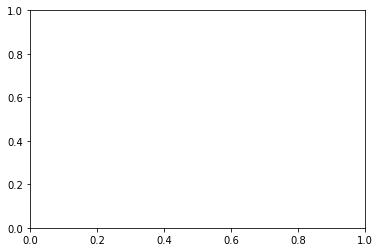

In [20]:
clfs = [cv_exp_NB_model,
cv_exp_LR_model,
cv_exp_KNN_model,
cv_exp_SVM_model,
cv_exp_MLP_model,
cv_th_LR_model,
cv_th_KNN_model,
cv_th_SVM_model,
cv_th_MLP_model,
b_h_voting_model,
th_h_voting_model,
b_s_voting_model,
th_s_voting_model,
d_bagging_model,
b_nb_bagging_model,
b_lr_bagging_model,
th_lr_bagging_model,
d_gradientboosting_model,
d_adaboost_model,
b_nb_adaboost_model,
b_lr_adaboost_model,
th_lr_adaboost_model]

for classifier in clfs:
    cv = StratifiedKFold(n_splits=10)
    mean_roc_curve(classifier, cv)

## Construção de pipeline para pré-tratamento (novas observações)

#### Remoção de ruído, correção de escrita e lowerização (caixa baixa)

In [53]:
# Remove non-ASCII characters from Kaggle databases (for tweet cleaning)
def remove_non_ASCII(title):
    title = title.encode("ascii", "ignore").decode()
    return title

# Remove noise
def remove_noise(title):
    title = ' '.join([t for t in title.split(' ') if not t.startswith('#') and not t.startswith('@') and not t.startswith('https:')])
    return title
    
# Remove ponctuation
def remove_ponct(title):
    ponct = ['.', ',', ';', ':', '!', '?', "\\", "/", "_", "-", '~']
    for p in ponct:
        title = title.replace(p, '')
    return title.strip()

# Neutralize accents
def neutralize_accents(title):
    return unidecode.unidecode(title)

# Spelling correction
def correct_spelling(title):
    title = TextBlob(title)
    title = str(title.correct())
    return title

# Lowerize words which are not proper name
def lowerize(title):
    # Get words
    words = [w for w in title.split(' ') if w]
    # Get unknown words (possibly proper names, after correction)
    unknown_words = spell.unknown(words)
    # Get proper names 
    tagged_sent = pos_tag(words)
    propernouns = [word for word,pos in tagged_sent if pos == 'NNP']
    # Lowerize if not identified as proper name and not identified as unknown word
    title = ' '.join([w.lower() if (w not in propernouns) and (w.lower() not in unknown_words) else w for w in words])
    return title

# Tokenize, lemmatize, stemmize
def tokenize_pipeline(title):
    title = scy(title)
    # Tokenize
    token_list = [token for token in title]
    # Remove Stop Words
    token_list = [t for t in token_list if str(t) not in nltk_sw]
    # Lemmatize
    lemma_list = [t.lemma_ for t in title]
    # Stemmize
    stem_list = [stemmer.stem(l) for l in lemma_list]
    # Remove Stop Words (reforce) + custom stop words (like keywords)
    custom_sw = []
    stem_list = [s for s in stem_list if s.lower() not in nltk_sw + custom_sw]
    # Remove lemmas which are digits
    stem_list = [s for s in stem_list if not s.isdigit()]
    return ' '.join(stem_list) # Returns joined text to fit TfIdf vectorizer corpus

def treatment_pipeline(title):
    title = remove_non_ASCII(title)
    title = remove_noise(title)
    title = remove_ponct(title)
    title = neutralize_accents(title)
    title = correct_spelling(title)
    title = lowerize(title)
    title = tokenize_pipeline(title)
    X_data = vectorizer.transform([title])
    X_data = LSA.transform(X_data)
    return X_data

In [31]:
inputs = "masks prevents covid"

response1 = NB_classifier.predict(treatment_pipeline(inputs))
response2 = LR_classifier.best_estimator_.predict(treatment_pipeline(inputs))
response3 = KNN_classifier.best_estimator_.predict(treatment_pipeline(inputs))
response4 = SVM_classifier.best_estimator_.predict(treatment_pipeline(inputs))
response5 = NN_classifier.best_estimator_.predict(treatment_pipeline(inputs))
print(f"NB: {'Fake news' if response1[0] else 'True information'}")
print(f"LR: {'Fake news' if response2[0] else 'True information'}")
print(f"KNN: {'Fake news' if response3[0] else 'True information'}")
print(f"SV: {'Fake news' if response4[0] else 'True information'}")
print(f"NN: {'Fake news' if response5[0] else 'True information'}")

NB: Fake news
LR: Fake news
KNN: True information
SV: Fake news
NN: True information


## Avaliação Out-of-Sample